# Mask R-CNN - Inspect Carplate Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import skimage.io as io
import skimage.color as color
import skimage.morphology as morphology
import skimage.feature as feature
import skimage.measure as measure
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


# Root directory of the project
ROOT_DIR = os.path.abspath(r"D:\LLPR\simple-car-plate-recognition-master\Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import carplate

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CARPLATE_WEIGHTS_PATH = r"D:\LLPR\simple-car-plate-recognition-master\logs\mask_rcnn_carplate_0030.h5"  # TODO: update this path

Using TensorFlow backend.


## Configurations

In [2]:
config = carplate.CarplateConfig()
CARPLATE_DIR = os.path.join(ROOT_DIR, "../dataset/carplate")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = carplate.CarplateDataset()
dataset.load_carplate(CARPLATE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'carplate']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0305 17:38:37.051923  7592 deprecation_wrapper.py:119] From C:\Users\Alex\AppData\Local\conda\conda\envs\mytensor\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0305 17:38:37.068914  7592 deprecation_wrapper.py:119] From C:\Users\Alex\AppData\Local\conda\conda\envs\mytensor\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0305 17:38:37.080905  7592 deprecation_wrapper.py:119] From C:\Users\Alex\AppData\Local\conda\conda\envs\mytensor\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0305 17:38:37.188844  7592 deprecation_wrapper.py:119] From C:\Users\Alex\AppData\Local\conda\conda\envs\mytensor\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is depre

In [8]:
weights_path = CARPLATE_WEIGHTS_PATH

In [9]:
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  D:\LLPR\simple-car-plate-recognition-master\logs\mask_rcnn_carplate_0030.h5


## Run Detection

image ID: carplate.image118.jpg (8) D:\LLPR\simple-car-plate-recognition-master\Mask_RCNN\../dataset/carplate\val\image118.jpg


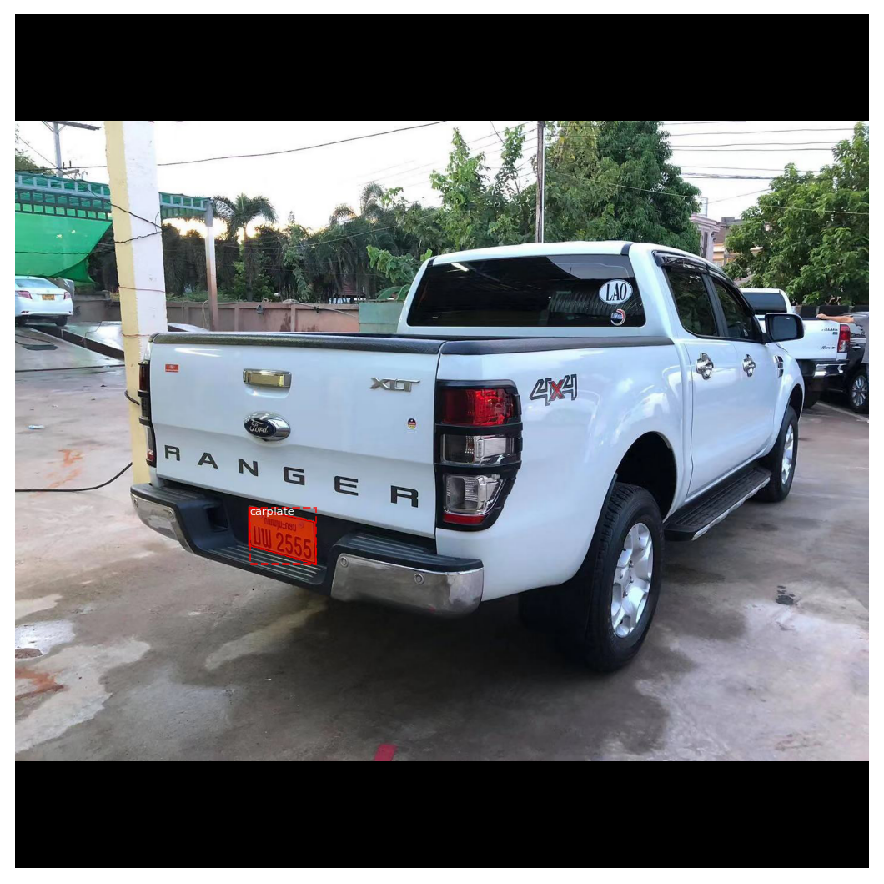

In [10]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  281.00000  max:  659.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


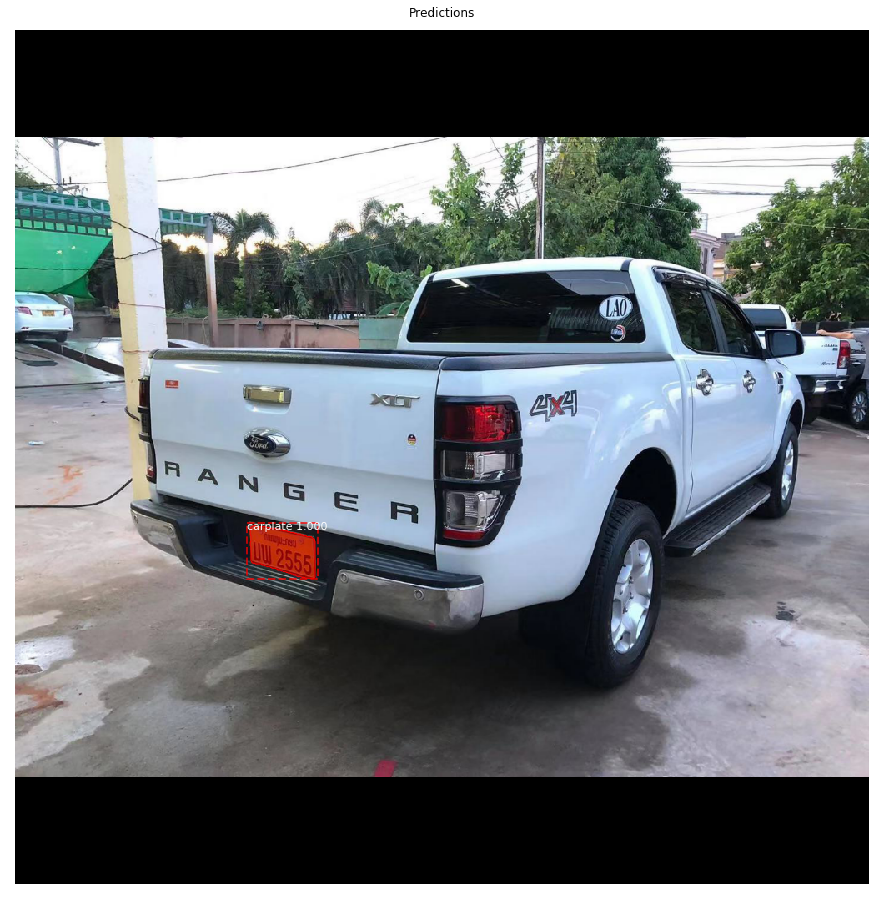

In [11]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

#นำภาพป้ายทะเบียนมาตัด จะข้ามขั้นตอน Detect ป้าย

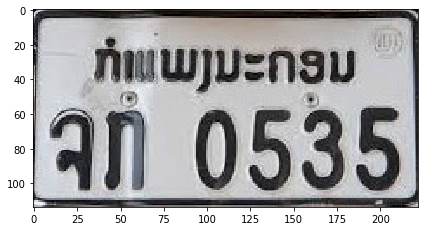

In [12]:
img = skimage.io.imread(r'D:\LLPR\simple-car-plate-recognition-master\6.jpg')
io.imshow(img)

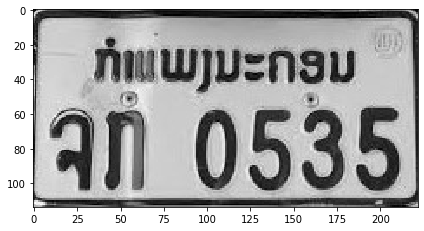

In [13]:
img2 = color.rgb2gray(img)
io.imshow(img2)

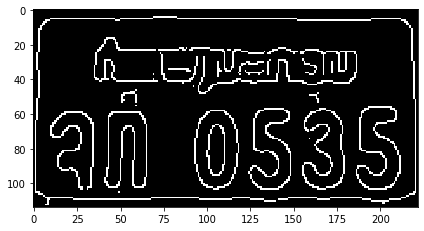

In [14]:
img3 = feature.canny(img2, sigma=3)
io.imshow(img3)

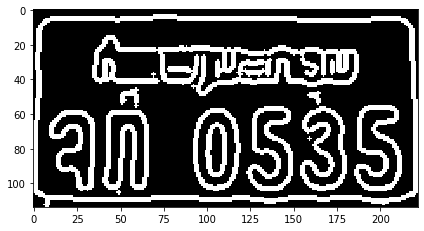

In [15]:
img4 = morphology.dilation(img3)
io.imshow(img4)

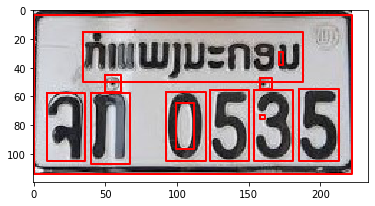

In [16]:
label_img = measure.label(img4)
regions = measure.regionprops(label_img)
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

def in_bboxes(bbox, bboxes):
    for bb in bboxes:
        minr0, minc0, maxr0, maxc0 = bb
        minr1, minc1, maxr1, maxc1 = bbox
        if minr1 >= minr0 and maxr1 <= maxr0 and minc1 >= minc0 and maxc1 <= maxc0:
            return True
    return False

bboxes = []
for props in regions:
    y0, x0 = props.centroid
    minr, minc, maxr, maxc = props.bbox
    
    #if maxc - minc > img4.shape[1] / 6 or maxr - minr < img4.shape[0] / 3:
    #    continue
        
    bbox = [minr, minc, maxr, maxc]
    #if in_bboxes(bbox, bboxes):
    #    continue
        
    #if abs(y0 - img4.shape[0] / 2) > img4.shape[0] / 4:
    #    continue
        
    bboxes.append(bbox)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2)


char_lim:  [38.0, 76.0, 22.200000000000003, 37.0]
prov_lim:  [28.5, 57.0, 55.5, 194.25]
props_w: 222, props_h: 111, y0: 57.65608465608466, x0: 109.9095238095238
False False
props_w: 154, props_h: 35, y0: 32.32693426410704, x0: 112.51192553810355
False False
props_w: 3, props_h: 9, y0: 33.0, x0: 172.0
False False
props_w: 11, props_h: 12, y0: 49.83076923076923, x0: 55.56923076923077
False False
props_w: 8, props_h: 8, y0: 49.96875, x0: 162.375
False False
props_w: 28, props_h: 50, y0: 79.953125, x0: 198.541015625
True False
props_w: 27, props_h: 49, y0: 80.54108216432866, x0: 136.70541082164328
True False
props_w: 27, props_h: 49, y0: 80.95705521472392, x0: 167.57668711656441
True False
props_w: 28, props_h: 48, y0: 80.46176470588236, x0: 105.26176470588236
True False
props_w: 27, props_h: 47, y0: 78.46501128668172, x0: 24.209932279909708
True False
props_w: 27, props_h: 49, y0: 81.23498233215548, x0: 53.64134275618375
True False
props_w: 13, props_h: 32, y0: 80.8274111675127, x0: 105.3

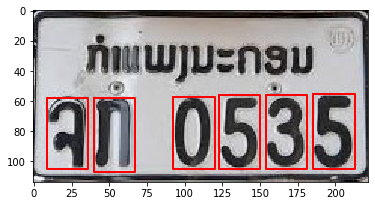

In [17]:
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

def in_bboxes(bbox, bboxes):
    for bb in bboxes:
        minr0, minc0, maxr0, maxc0 = bb
        minr1, minc1, maxr1, maxc1 = bbox
        if minr1 >= minr0 and maxr1 <= maxr0 and minc1 >= minc0 and maxc1 <= maxc0:
            return True
    return False

plate_h, plate_w = img4.shape
## h_min, h_max, w_min, w_max
char_lim = [plate_h*(1/3), plate_h*(2/3), plate_w*(1/10), plate_w*(1/6)]
prov_lim = [plate_h*(1/4), plate_h*(1/2), plate_w*(2/8), plate_w*(7/8)]

print('char_lim: ', char_lim)
print('prov_lim: ', prov_lim)

bboxes = []
for props in regions:
    y0, x0 = props.centroid
    minr, minc, maxr, maxc = props.bbox
    props_w = maxc - minc
    props_h = maxr - minr
    print(F'props_w: {props_w}, props_h: {props_h}, y0: {y0}, x0: {x0}')
    
#    if maxc - minc > img4.shape[1] / 6 or maxr - minr < img4.shape[0] / 3:
#        continue
    found_char = False
    found_prov = False

    # character on lower half.
    if props_h>char_lim[0] and props_h<char_lim[1] and props_w>char_lim[2] and props_w<char_lim[3] and y0>plate_h/2:
        found_char = True
    
    # province on upper half.
    #if props_h>prov_lim[0] and props_h<prov_lim[1] and props_w>prov_lim[2] and props_w<prov_lim[3] and y0<plate_h/2:
        #found_prov = True
        
    print(found_char, found_prov)
    if not (found_char or found_prov):
        continue
    
    bbox = [minr, minc, maxr, maxc]
    if in_bboxes(bbox, bboxes):
        continue
        
    if abs(y0 - img4.shape[0] / 2) > img4.shape[0] / 4:
        continue
        
    bboxes.append(bbox)
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2)

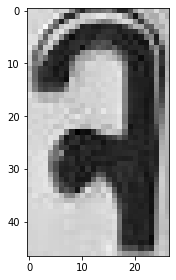

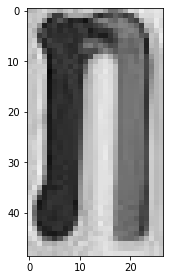

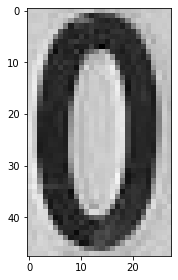

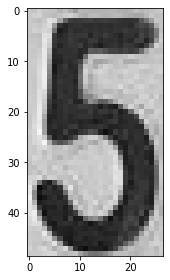

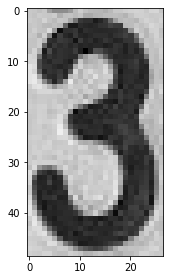

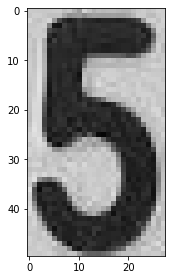

In [18]:
bboxes = sorted(bboxes, key=lambda x: x[1])
chars = []
for bbox in bboxes:
    minr, minc, maxr, maxc = bbox
    ch = img2[minr:maxr, minc:maxc]
    chars.append(ch)
    io.imshow(ch)
    plt.show()

In [19]:
DATASET_DIR = (r'D:\LLPR\simple-car-plate-recognition-master\dataset')
classes = os.listdir(DATASET_DIR + "/ann")

num_classes = len(classes)
img_rows, img_cols = 20, 20

if K.image_data_format() == 'channels_first':
    input_shape = [1, img_rows, img_cols]
else:
    input_shape = [img_rows, img_cols, 1]

In [20]:
num_classes

30

In [21]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

W0305 17:40:08.534961  7592 deprecation.py:506] From C:\Users\Alex\AppData\Local\conda\conda\envs\mytensor\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0305 17:40:08.691436  7592 deprecation_wrapper.py:119] From C:\Users\Alex\AppData\Local\conda\conda\envs\mytensor\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [22]:
weights_char = (r"D:\LLPR\simple-car-plate-recognition-master\char_cnn\char_cnn.h5")

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 18, 18, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               524416    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [24]:
print("Loading weights ", weights_char)
model.load_weights(weights_char)

Loading weights  D:\LLPR\simple-car-plate-recognition-master\char_cnn\char_cnn.h5


In [25]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

In [26]:
chars2 = []
for ch in chars:
    resized_char = skimage.transform.resize(ch, [img_rows, img_cols])
    stretched_gray = (resized_char - resized_char.min())/(resized_char.max() - resized_char.min())
    chars2.append(stretched_gray)
    
chars2 = np.stack(chars2)

In [27]:
ys = np.unique(classes)

p_test = model.predict_classes(extend_channel(chars2))
print(' '.join([ys[p_test[i]] for i in range(len(p_test))]))

ຈ ກ 0 5 3 5


## ทดสอบ

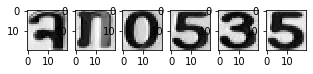

In [28]:
fig, axs = plt.subplots(1,6, figsize=(5, 10))
for i in range(6):
    axs[i].imshow(chars2[i], cmap='gray')
plt.show()

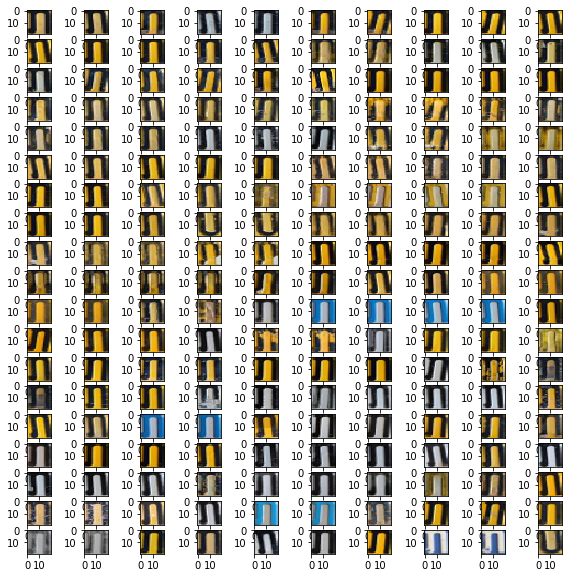

In [169]:
f5path = (r'D:\LLPR\simple-car-plate-recognition-master\dataset\ann\ກ')
f5 = os.listdir(f5path)

nsamp = len(f5)
ncol = 10
nrow = nsamp//ncol

fig, axs = plt.subplots(nrow, ncol, figsize=(10, 10))

for r in range(nrow):
  for c in range(ncol):
    f = f5[r*ncol + c]
    path5 = os.path.join(f5path, f)
    #img5 = color.rgb2gray(skimage.io.imread(path5))
    img5 = skimage.io.imread(path5)
    img5 = skimage.transform.resize(img5, [img_rows, img_cols])
    axs[r][c].imshow(img5, cmap='gray')
plt.show()
